In [ ]:
from quspin.operators import hamiltonian
from quspin.basis import spinless_fermion_basis_1d, spinful_fermion_basis_1d
from pyscf import gto, scf
import numpy as np
import scipy as sp
from scipy.linalg import eigh
from copy import deepcopy
import matplotlib.pyplot as plt
from utils.spatial2spin import spinorb_from_spatial_ovlp

converged SCF energy = -1.57561647670187
N_ao = 4
N_ele = 4


# Quantum Chemistry

In [ ]:
# Define the molecule

mol = gto.M(
    atom='''
H 0 0 0
H 0 0 2
H 0 0 4
H 0 0 6
''',
    basis='sto3g', 
    #spin = 1,
    unit='angstrom'
)

# Perform Hartree-Fock calculation
mf = scf.RHF(mol)
mf.kernel()
print(f'N_ao = {mol.nao}')
print(f'N_ele = {mol.tot_electrons()}')
n_qubits = int(2 * mol.nao)
n_ele = int(mol.tot_electrons())
e_nuc = mol.energy_nuc()

##### define molecular Hamiltonians ###
def get_integrals(mol:gto.M):
    e1, ovlp, eri = mol.intor('int1e_nuc')+mol.intor('int1e_kin'), mol.intor('int1e_ovlp'), mol.intor('int2e')
    # read: (ij|kl) -> (ik|jl) = <ij|kl> (if the spin is right)
    eri = np.transpose(eri, (0,2,1,3)) 
    e1_spin, ovlp_spin, eri_spin = spinorb_from_spatial_ovlp(e1, ovlp, eri)
    return e1_spin, ovlp_spin, eri_spin

## compute the fock operators
# fock_kl = h_kl + V_kl - K_kl
def get_fock(rho, e1_spin, eri_spin):
    fock = e1_spin + np.einsum('pq, kplq', rho, eri_spin, optimize = True) - np.einsum('pq, kpql', rho, eri_spin, optimize = True)
    return(fock)

def get_energy(rho, e1_spin, eri_spin):
    return np.einsum('kl,kl',rho,e1_spin)\
             +0.5*np.einsum('kl,pq,kplq',rho,rho,eri_spin,optimize=True)\
             -0.5*np.einsum('kq,pl,kplq',rho,rho,eri_spin,optimize=True)

def get_first_order(rho, eri_spin):
    return -0.5*np.einsum('kl,pq,kplq',rho,rho,eri_spin,optimize=True)\
             +0.5*np.einsum('kq,pl,kplq',rho,rho,eri_spin,optimize=True)
    

e1_spin, ovlp_spin, eri_spin = get_integrals(mol)
## initialize coefficient matrix \Phi and density matrix \rho
Phi0 = np.zeros((n_qubits,n_qubits))
rho0 = np.dot(Phi0[:,:n_ele],Phi0[:,:n_ele].T)

## SCF iterations
def scf_iteration(e1_spin, eri_spin, verbose = False, Phi = Phi0, rho = rho0, TOL = 1e-15):
    last_energy = 0
    cycle = 0
    while True:
        cycle += 1
        fock = get_fock(rho, e1_spin, eri_spin)
        # solve FC = SCE, renew Phi
        e_val, Phi = eigh(fock,ovlp_spin)
        # calculate new density matrix
        rho = np.dot(Phi[:,:n_ele],Phi[:,:n_ele].T)
        # calculate energy
        energy = get_energy(rho, e1_spin, eri_spin)
        if verbose:
            print('{} iteration, ground energy = {:5f}'.format(cycle,energy+e_nuc))
        if np.abs(energy-last_energy)<TOL:
            print('Energy Converged.')
            if verbose:
                print('The converged HF energy is {:5f}'.format(energy+e_nuc))
            break
        else:
            last_energy = energy
    return energy+e_nuc, fock, rho

# Perform Hartree-Fock Calculations

In [ ]:
HF_energy, fock, rho = scf_iteration(e1_spin, eri_spin, verbose = False)

def get_quadratic_fock(fock): 
    # orthogonalize the atomic orbitals and write down the coefficient matrix of the quadratic Hamiltonian form of the converged Fock operator
    s, U = np.linalg.eigh(ovlp_spin)
    sqrt_sinv = np.diag(np.sqrt(np.reciprocal(s)))
    X = U @ sqrt_sinv
    fock_pr = X.T @ fock @ X
    return fock_pr

def get_fock_hamilitonian(fock_pr, rho):
    print("==== ready to construct the Fock Hamiltonian \sum_k F_pq a_p^dag a_q ====")
    # quspin setting
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

    ## converged HF hamiltonian
    Hfock = []
    for i in range(n_qubits):
        for j in range(n_qubits):
            if abs(fock_pr[i][j]) > 1e-15:
                Hfock.append([fock_pr[i][j], i, j]) # a_i^+ a_j, '+-'
    fermbas = spinless_fermion_basis_1d(n_qubits, Nf = n_ele) # restrict to the 2 sector
    H_fock = hamiltonian([['+-', Hfock]],[], basis=fermbas, dtype=np.float64,**no_checks)
    H_mat = np.array(H_fock.todense())
    print(f'This is a matrix with size binom(N_qubit, N_ele)= binom({n_qubits}, {n_ele}) = {H_mat.shape[0]}')
    e, evc = np.linalg.eigh(H_mat)
    print(f'The ground eigenvalue (\sum e_i) is {e[0]}')
    #HFGS = evc.T[0]

    HF_energy = e[0]  + get_first_order(rho, eri_spin) + e_nuc
    print(f'The HF energy is {HF_energy}')
    print('========')
    return H_mat, HF_energy

fock_pr = get_quadratic_fock(fock)
H_mat, HF_energy = get_fock_hamilitonian(fock_pr, rho)

e_orb = eigh(fock_pr)[0] 
print(f'list of single orbital energies : {e_orb}')

sum_ei = 0
occ = 0
for i in range(len(e_orb)):
    if e_orb[i] > 0:
        print(f'occ number = {occ}')
        print(f'sum_ei = {sum_ei}') # the summation of single orbital energy
        break
    else:
        occ += 1
        sum_ei += e_orb[i]


# Computing the digonal Hartree-Fock Hamiltonian within the molecular basis
Lambda, _ = np.linalg.eigh(fock_pr)
fermbas_test = spinless_fermion_basis_1d(n_qubits, Nf = n_ele)
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H_op = hamiltonian([['+-', [[Lambda[i], i, i] for i in range(len(Lambda))]]],[], basis=fermbas_test, dtype=np.float64,**no_checks).toarray()

print('Converged HartreeFock Hamiltonian computed!')

Energy Converged.


# Lindblad Coupling/Jump Operators

In [ ]:
print("*****computing coupling operators*****")
sectors_cand = [(i_u, n_ele - i_u) for i_u in range(n_ele+1)]
sectors = []
for conf in sectors_cand:
    if conf[0] <= mol.nao and conf[1] <= mol.nao:
        sectors.append(conf)
print("physical sectors", sectors)
fermbas_spinful = spinful_fermion_basis_1d(int(mol.nao), Nf=sectors)
couplist = []
L = int(mol.nao)
for i in range(L):
    for j in range(L):
        couplist += [['+|-',[[1,i,j]]], ['-|+',[[1,i,j]]], ['+-|',[[1,i,j]]], ['|+-',[[1,i,j]]]]
print("total coupling operators =", len(couplist))
A_all_op = [hamiltonian([fermop], [], basis = fermbas_spinful, dtype = np.float64, **no_checks) for fermop in couplist] #quad_multi
A_mat_list = [Aop.tocsr() for Aop in A_all_op]


def ComputeJumpFilterFree(H_mat, coupling):
    H_mat_copy = deepcopy(H_mat)
    E_H, psi_H = eigh(H_mat_copy)
    print("Diagonlized")
    A_ovlp = (psi_H).conj().T @ coupling @ psi_H
    print("A_ovlp computed")  
    K = np.triu(A_ovlp, k = 1)
    K = psi_H @ K @ (psi_H).conj().T
    return sp.sparse.csr_matrix(K)

K_matlist = []
for i in range(len(A_mat_list)):
    print("*************ComputeJump {}/{}*************".format(i+1, len(A_mat_list)))
    K_matlist.append(ComputeJumpFilterFree(H_op, A_mat_list[i]))

*****computing coupling operators*****
physical sectors [(0, 4), (1, 3), (2, 2), (3, 1), (4, 0)]
total coupling operators = 64


# Exact Propagation of Many-Body Density Matrix

In [ ]:
def get_diffeq(rho, H_mat, K_matlist):
    #-i[H,rho]
    coherent = -1j*(H_mat@rho - rho@H_mat)
    dissip = np.zeros_like(rho)+0j
    #\sum K_k rho K_k^dag - 1/2 {K_k^dag K_k, rho}
    for jumps in K_matlist:
        dissip += jumps @ rho @ jumps.conj().T - 0.5 * (jumps.conj().T @ jumps @ rho + rho @ jumps.conj().T @ jumps)
    return coherent + dissip


def compute_energy_mnbd(rho, H_mat):
    return np.real(np.trace(rho@H_mat))

# RK_dopri 5 with adaptive step
def DOPRI5(f, y0, t_initial, t_final, H_mat, K_matlist, h=0.01, atol=1e-6, rtol=1e-6):
    a = np.array([0, 1 / 5, 3 / 10, 4 / 5, 8 / 9, 1, 1])
    b = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [1 / 5, 0, 0, 0, 0, 0, 0],
                  [3 / 40, 9 / 40, 0, 0, 0, 0, 0],
                  [44 / 45, -56 / 15, 32 / 9, 0, 0, 0, 0],
                  [19372 / 6561, -25360 / 2187, 64448 / 6561, -212 / 729, 0, 0, 0],
                  [9017 / 3168, -355 / 33, 46732 / 5247, 49 / 176, -5103 / 18656, 0, 0],
                  [35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84, 0]])
    c = np.array([35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84, 0])
    c_star = np.array([5179 / 57600, 0, 7571 / 16695, 393 / 640, -92097 / 339200, 187 / 2100, 1 / 40])

    t, y = t_initial, deepcopy(y0+0j)
    t_end = t_final
    h_lst = []
    N = len(y0)

    if t_final < t_initial and h > 0:
        h = -h  # Set step size to negative for backward evolution
    while (h > 0 and t < t_end) or (h < 0 and t > t_end):
        if (h > 0 and t + h > t_end) or (h < 0 and t + h < t_end):
            h = t_end - t

        k = np.zeros((7, N, N), dtype=complex)

        for i in range(7):
            y_i = y.copy()
            for j in range(i):
                y_i += h * b[i, j] * k[j]
            k[i] = f(y_i, H_mat, K_matlist)      

        y_next = y.copy()
        for i in range(7):
            y_next += h * c[i] * k[i]

        y_star = y.copy()
        for i in range(7):
            y_star += h * c_star[i] * k[i]

        diff = np.abs(y_next-y_star)
        scale = atol + rtol * np.maximum(np.abs(y_next), np.abs(y_star))
        err = np.linalg.norm(diff/scale, ord=2)/np.sqrt(N)

        rho = (1/err)**0.2

        if err <= 1:
            h_lst.append(h)
            t = t + h
            y = y_next
        fac = min(2, max(0.8 * rho, 0.5))
        h = fac*h

    return y

# 1-Reduced Density Matrix

In [ ]:
# list of c_r^dag c_s
crcslist = [
    [hamiltonian([['+-', [[1, i, j]]]],[], basis=fermbas_test, dtype=np.float64,**no_checks).toarray() for j in range(n_qubits)]
    for i in range(n_qubits)
]

def get_1rdm(rho):
    onerdm = np.zeros([n_qubits, n_qubits]) + 0j
    for i in range(n_qubits):
        for j in range(n_qubits):
            onerdm[i][j] = np.trace(rho @ crcslist[j][i]) # Tr(\rho c_j^\dagger c_i)
    return onerdm

psi0 = np.random.rand(H_mat.shape[0]) + 0j
psi0 /= np.linalg.norm(psi0)
psi0 = sp.sparse.csc_matrix(psi0).T

In [127]:
# exact trajectory of the lindblad dynamics
def trajectory_exact(rho0, H_mat, K_matlist, Lambda, T, tau):
    t = 0
    energy = []
    onerdm = []
    EnergyUsingOneRdm = []
    rho = deepcopy(rho0)
    n_step = int(T/tau)
    for _ in range(n_step+1):
        energy.append(compute_energy_mnbd(rho, H_mat))
        OneRdm_Temp = get_1rdm(rho)
        onerdm.append(OneRdm_Temp)
        EnergyUsingOneRdm.append(np.trace(np.diag(Lambda) @ OneRdm_Temp))
        #ovlp.append(compute_energy_mnbd(rho, rho_GS))
        rho = DOPRI5(get_diffeq, rho, 0, tau, H_mat, K_matlist, h=tau/10)
        
        t += tau
        print(t)
        print('energy = {}, partinumber = {}, EnerUsing1RDM = {}'.format(energy[-1], round(np.real(np.trace(OneRdm_Temp))), np.trace(np.diag(Lambda) @ OneRdm_Temp)))
    return np.array(energy), onerdm


# Exact Solution

In [128]:
# exact solution
psi0 = np.random.rand(H_op.shape[0]) + 0j
psi0 /= np.linalg.norm(psi0)
psi0 = sp.sparse.csc_matrix(psi0).T
psi0arr = deepcopy(psi0).toarray()
initial = np.outer(psi0arr, psi0arr.conj())

dt = 0.1
T = 10
energy_exact, onerdm_traj = trajectory_exact(initial, H_op, K_matlist, Lambda, T, dt)

0.1
energy = -0.25020655295247535, partinumber = 4, EnerUsing1RDM = (-0.2502065529524753+0j)
0.2
energy = -0.5612143503056684, partinumber = 4, EnerUsing1RDM = (-0.5612143503056684+0j)
0.30000000000000004
energy = -0.7828982808641013, partinumber = 4, EnerUsing1RDM = (-0.7828982808641014+0j)
0.4
energy = -0.9481018865816682, partinumber = 4, EnerUsing1RDM = (-0.948101886581668+0j)
0.5
energy = -1.0757165401241073, partinumber = 4, EnerUsing1RDM = (-1.0757165401241071+0j)
0.6
energy = -1.177255046253796, partinumber = 4, EnerUsing1RDM = (-1.1772550462537958+0j)
0.7
energy = -1.2600681404655778, partinumber = 4, EnerUsing1RDM = (-1.2600681404655778+0j)
0.7999999999999999
energy = -1.329023485166289, partinumber = 4, EnerUsing1RDM = (-1.3290234851662892+0j)
0.8999999999999999
energy = -1.387439341294269, partinumber = 4, EnerUsing1RDM = (-1.387439341294269+0j)
0.9999999999999999
energy = -1.437633708398584, partinumber = 4, EnerUsing1RDM = (-1.4376337083985837+0j)
1.0999999999999999
energ

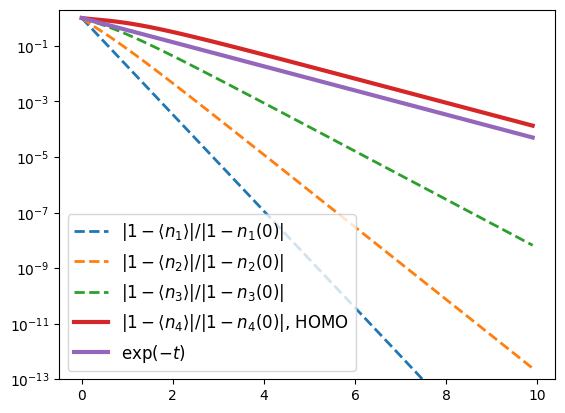

In [150]:
for OrbInd in range(0, n_ele):
    time = [dt*k for k in range(int(T/dt))]
    Prrlist = [abs(1-onerdm_traj[t][OrbInd][OrbInd])/abs(1-onerdm_traj[0][OrbInd][OrbInd]) for t in range(int(T/dt))]
    plt.yscale('log')
    if OrbInd == n_ele-1:
        plt.plot(time, Prrlist, label = r'$\vert 1-\langle n_{}\rangle \vert/\vert 1-n_{}(0)\vert$, HOMO'.format(OrbInd+1, OrbInd+1), linewidth = 3)
    else:
        plt.plot(time, Prrlist, label = r'$\vert 1-\langle n_{} \rangle\vert/\vert 1-n_{}(0) \vert$'.format(OrbInd+1, OrbInd+1), linestyle = '--', linewidth = 2)
    plt.ylim(1e-13, 2)
plt.plot(time, [np.exp(-1*t) for t in time], label = r'$\exp(-t)$', linewidth = 3)
plt.legend(fontsize = 12)
plt.show()

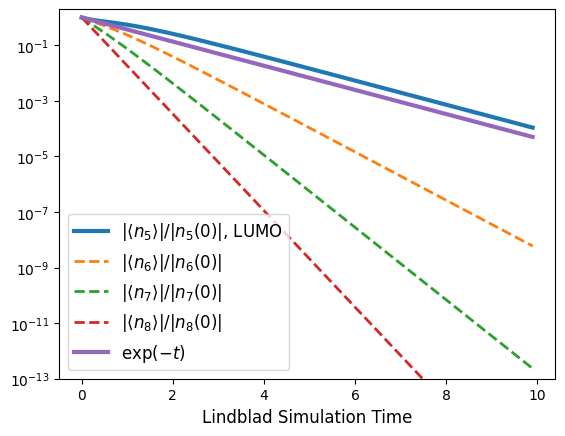

In [157]:
for OrbInd in range(n_ele, n_qubits):
    time = [dt*k for k in range(int(T/dt))]
    Prrlist = [abs(onerdm_traj[t][OrbInd][OrbInd])/abs(onerdm_traj[0][OrbInd][OrbInd]) for t in range(int(T/dt))]
    plt.yscale('log')
    if OrbInd == n_ele:
        plt.plot(time, Prrlist, label = r'$\vert\langle n_{}\rangle\vert/\vert n_{}(0)\vert$, LUMO'.format(OrbInd+1, OrbInd+1), linewidth = 3)
    else:
        plt.plot(time, Prrlist, label = r'$\vert \langle n_{}\rangle\vert/\vert n_{}(0)\vert$'.format(OrbInd+1, OrbInd+1), linestyle = '--', linewidth = 2)
    plt.ylim(1e-13, 2)
plt.plot(time, [np.exp(-1*t) for t in time], label = r'$\exp(-t)$', linewidth = 3)
plt.legend(fontsize = 12)
plt.xlabel('Lindblad Simulation Time', fontsize = 12)
plt.show()

# Energy Evolution Agnostic to Chemical Details

In [134]:
H1, H2, H3, H4 = np.load('hamiltonians/sto3g_H4_chain.npy'), np.load('hamiltonians/sto6g_H4_chain.npy'), np.load('hamiltonians/sto3g_H4_ring.npy'), np.load('hamiltonians/sto6g_H4_ring.npy')

F1, F2, F3, F4 = np.load('hamiltonians/sto3g_H4_CLambda.npy'), np.load('hamiltonians/sto6g_H4_CLambda.npy'), np.load('hamiltonians/sto3g_H4_RLambda.npy'), np.load('hamiltonians/sto6g_H4_RLambda.npy')
ener_result = []

for H_mat, Lambda in zip([H1, H2, H3, H4], [F1, F2, F3, F4]):
    
    print("*****computing coupling operators*****")
    sectors_cand = [(i_u, n_ele - i_u) for i_u in range(n_ele+1)]
    sectors = []
    for conf in sectors_cand:
        if conf[0] <= L and conf[1] <= L:
            sectors.append(conf)
    print("physical sectors", sectors)
    couplist = []
    L = int(mol.nao)
    for i in range(L):
        for j in range(L):
            couplist += [['+|-',[[1,i,j]]], ['-|+',[[1,i,j]]], ['+-|',[[1,i,j]]], ['|+-',[[1,i,j]]]]
    print("total number of coupling operators =", len(couplist))
    A_all_op = [hamiltonian([fermop], [], basis = fermbas_spinful, dtype = np.float64, **no_checks) for fermop in couplist] #quad_multi
    A_mat_list = [Aop.tocsr() for Aop in A_all_op] 
    K_matlist = []
    for i in range(len(A_mat_list)):
        print("*************ComputeJump {}/{}*************".format(i+1, len(A_mat_list)))
        K_matlist.append(ComputeJumpFilterFree(H_mat, A_mat_list[i]))

    dt = 0.1
    T = 10
    energy_exact, onerdm_traj = trajectory_exact(initial, H_mat, K_matlist, Lambda, T, dt)
    ener_result.append(energy_exact)
    

*****computing coupling operators*****
physical sectors [(0, 4), (1, 3), (2, 2), (3, 1), (4, 0)]
total number of coupling operators = 64
*************ComputeJump 1/64*************
Diagonlized
A_ovlp computed
*************ComputeJump 2/64*************
Diagonlized
A_ovlp computed
*************ComputeJump 3/64*************
Diagonlized
A_ovlp computed
*************ComputeJump 4/64*************
Diagonlized
A_ovlp computed
*************ComputeJump 5/64*************
Diagonlized
A_ovlp computed
*************ComputeJump 6/64*************
Diagonlized
A_ovlp computed
*************ComputeJump 7/64*************
Diagonlized
A_ovlp computed
*************ComputeJump 8/64*************
Diagonlized
A_ovlp computed
*************ComputeJump 9/64*************
Diagonlized
A_ovlp computed
*************ComputeJump 10/64*************
Diagonlized
A_ovlp computed
*************ComputeJump 11/64*************
Diagonlized
A_ovlp computed
*************ComputeJump 12/64*************
Diagonlized
A_ovlp computed
********

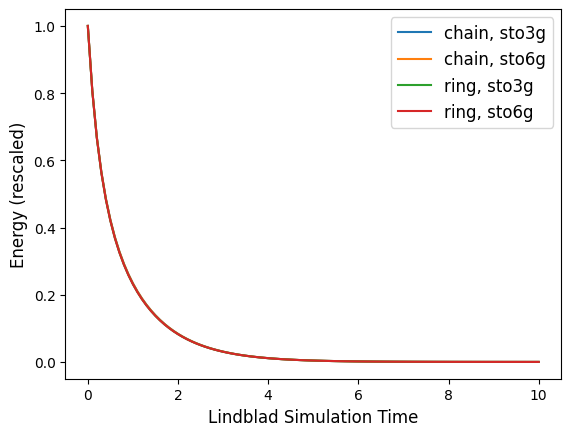

In [158]:
Res1, Res2, Res3, Res4 = ener_result[0], ener_result[1], ener_result[2], ener_result[3]
E1, E2, E3, E4 = -1.85684059, -1.87481086, -1.85212263 , -1.87028379
Res1 = [(e - E1)/(Res1[0] - E1) for e in Res1]
Res2 = [(e - E2)/(Res2[0] - E2) for e in Res2]
Res3 = [(e - E3)/(Res3[0] - E3) for e in Res3]
Res4 = [(e - E4)/(Res4[0] - E4) for e in Res4]
time = [dt*k for k in range(int(T/dt)+1)]
plt.plot(time, Res1, label = 'chain, sto3g')
plt.plot(time, Res2, label = 'chain, sto6g')
plt.plot(time, Res3, label = 'ring, sto3g')
plt.plot(time, Res4, label = 'ring, sto6g')
plt.legend(fontsize = 12)
plt.xlabel('Lindblad Simulation Time', fontsize = 12)
plt.ylabel('Energy (rescaled)', fontsize = 12)
plt.show()